In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn, gen_sini_Xthetas
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear, SIS_GLIM
from hdf_utils.utils import gen_lam_seq
from hdf_utils.hypo_test import  MS2idxs, obt_test_stat_simple2
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv, gen_Dmat 
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl, bcross_entropy_loss
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_logi_fn
from optimization.opt import optimization
from penalties.scad_pen import SCAD
from models.logistic_model import LogisticModel
from optimization.variable_selection import GIC_fn, GCV_fn

from joblib import Parallel, delayed

In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Param and fns

## Params

In [6]:
np.random.seed(0)
#obt_bsp = obt_bsp_obasis_Rfn
obt_bsp = obt_bsp_basis_Rfn_wrapper
paras = edict(def_paras.copy())



# Others
paras.num_rep = 200 
paras.init_noise_sd = -1 # the sd of the noise added to the true value for initial values, if -1, make init 0
paras.SIS_ratio = 0.20 # the ratio to keep with SIS procedure
paras.linear_theta_update="cholesky_inv"

# candidate sets of tuning parameters, only two 
# lambda: penalty term
# N: num of basis
paras.can_lams = [0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 1, 2, 8] # for non
paras.can_lams = [0.001, 0.3, 0.6, 0.8, 1, 1.2, 1.4, 2, 16] # for orthogonal basis
paras.can_Ns = [4, 6, 8]


# generating dataset
paras.n = 200 # num of data obs to be genareted
paras.npts = 100 # num of pts to evaluate X(s)
paras.d = 68 # num of ROIs
paras.q = 3 # num of other covariates
paras.types_ = ["int", "c", 2]
paras.srho = 0.3 # corr from sinica
paras.is_std = False # std PSD or not

# b-spline
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mats = []
for N in paras.can_Ns:
    paras.basis_mats.append(
        torch.tensor(obt_bsp(paras.x, N, paras.ord)).to(torch.get_default_dtype())
    )

# True parameters
paras.alp_GT = np.array([-1, -1, 2])
# fourier basis
cs = [0.0, 0.0, 0.0] # for sinica paper
paras.fourier_basis = fourier_basis_fn(paras.x)[:, :]
paras.fourier_basis_coefs = ([cs[0]*coef_fn(0.2), cs[1]*coef_fn(0.2), cs[2]*coef_fn(0.2)] + 
                             [np.zeros(50)] * (paras.d-3-1) +
                             [coef_fn(0.2)]
                             )
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T 
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs
print(np.linalg.norm(paras.beta_GT, axis=0))

paras.Gam_GT_ests = [(np.linalg.inv(basis_mat.numpy().T 
                                  @ basis_mat.numpy()) 
                                  @ basis_mat.numpy().T 
                                  @ paras.beta_GT) 
                     for basis_mat in paras.basis_mats]

# optimization
# not used, to use it, you have to know GT
#Rmins = [(2*(np.linalg.norm(paras.Gam_GT_ests[ix]
#                            /np.sqrt(paras.can_Ns[ix]), axis=0).sum() 
#           + np.abs(paras.alp_GT).sum())) 
#        for ix in range(len(paras.can_Ns))]
#paras.Rmin = np.max(Rmins)
paras.Rmin = 100000
paras.Rfct = 2
paras.stop_cv = 5e-4
paras.max_iter = 10000
paras.num_cv_fold = 5

paras.NR_eps = 1e-4 # the stop criteria for Newton-Ralpson method, only for logistic model
paras.NR_maxit = 100

paras.cv_is_center = True
paras.cv_SIS_ratio = 0.2
paras.cv_SIS_pen = 1
paras.cv_SIS_basis_mat = torch.tensor(obt_bsp(paras.x, 6, paras.ord)).to(torch.get_default_dtype())
paras.num_cv_fold = 5
paras.cv_init_noise_sd = -1


# hypothesis test
#without loss of generality, we assume the idxs in M is the first m betas
paras.sel_idx = np.arange(1, paras.d) # M^c set, 
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
paras.Cmats = [
    np.eye(len(paras.M_idxs)), # m x m I matrix, [beta1, beta2] = [0, 0]
]
paras.svdinv_eps_Q = 1e-7 # now 0 means inverse, small value like 0.01 means remove small eig vals.
paras.svdinv_eps_Psi = 1e-7

paras.save_dir = RES_ROOT/"simu_linear_sinica_samebetaX_tmp"
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         14.87358566]


## Fns

In [7]:
def _is_exists(tmp_paras):
    """
    Check if a file with the given parameters exists.

    Args:
    tmp_paras:
        d (int): The value of d in the file name.
        n (int): The value of n in the file name.
        npts:
        is_std
        seed (int): The seed value in the file name.

    Returns:
    bool or Path: Returns the file path if the file exists, otherwise returns False.
    """
    _get_n = lambda fil: int(fil.stem.split("_")[2].split("-")[-1])
    fils = MIDRES_ROOT.glob(f"PSD_d-{tmp_paras.d}_n-*npts-{tmp_paras.npts}_is_std-{tmp_paras.is_std}")
    # We do not need fil with n as we know the data with corresponding seed does not exist
    fils = [fil for fil in fils if _get_n(fil) !=tmp_paras.n]
    if len(fils) == 0:
        return False
    else:
        fils = sorted(fils, key=_get_n)
        ns = np.array([_get_n(fil) for fil in fils])
        idxs = np.where(tmp_paras.n <= ns)[0]
        if len(idxs) == 0:
            return False
        else:
            fil =fils[idxs[0]]
            path = MIDRES_ROOT/fil/f"seed_{tmp_paras.seed}.pkl"
            return path if path.exists() else False
def _get_filename(params):
    keys = ["d", "n", "npts", "is_std"]
    folder_name = 'PSD_'+'_'.join(f"{k}-{params[k]}" for k in keys)
    return folder_name + f'/seed_{params.seed}.pkl'
def _gen_simu_data_all_PSD(seed, paras, verbose=False, is_gen=False):
    """
    Generate simulated data for all parameters.

    Args:
        seed (int): Seed for random number generator.
        paras (dict): Dictionary containing the following parameters:
            - n (int): Number of samples.
            - d (int): Number of dimensions.
            - q (int): Number of covariates.
            - types_ (list): List of types for generating covariates.
            - alp_GT (list): List of ground truth alpha values.
            - beta_GT (list): List of ground truth beta values.
            - freqs (list): List of frequencies for generating simulated PSD.
            - sigma2 (float): Variance of the noise.
        verbose(bool): Verbose or not
        is_gen(bool): Only for generating or not. If True, only checking or generating X, not return anything.

    Returns:
        all_data (dict): Dictionary containing the following simulated data:
            - X (torch.Tensor): Tensor of shape (n, d, npts) containing the simulated PSD.
            - Y (torch.Tensor): Tensor of shape (n,) containing the response variable.
            - Z (torch.Tensor): Tensor of shape (n, q) containing the covariates.
    """
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    con_idxs = [typ =="c" for typ in _paras.types_]
    tmp_paras = edict()
    tmp_paras.seed = seed 
    tmp_paras.n = _paras.n
    tmp_paras.d = _paras.d
    tmp_paras.npts = _paras.npts
    tmp_paras.is_std = _paras.is_std
    
    file_path = MIDRES_ROOT/_get_filename(tmp_paras)
    if file_path.exists():
        if is_gen:
            return None
        simu_curvs = load_pkl(file_path, verbose=verbose)
    else:
        ofil =  _is_exists(tmp_paras)
        if ofil:
            if is_gen:
                return None
            simu_curvs = load_pkl(ofil, verbose=verbose)
        else:
            if _paras.is_std:
                simu_curvs = gen_simu_psd(_paras.n, _paras.d, _paras.freqs, prior_sd=10, n_jobs=28, is_prog=False, is_std=_paras.is_std)
            else:
                simu_curvs = gen_simu_psd(_paras.n, _paras.d, _paras.freqs, prior_sd=10, n_jobs=28, is_prog=False, is_std=_paras.is_std)
                simu_curvs = simu_curvs - simu_curvs.mean(axis=-1, keepdims=True); # not std, but center it
            save_pkl(file_path, simu_curvs, verbose=verbose)
    if is_gen:
        return None
    simu_curvs = simu_curvs[:_paras.n]
    simu_curvs = (simu_curvs + np.random.randn(*simu_curvs.shape)*5)*1 # larger
    #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts)* 10
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    probs = logit_fn(lin_term)
    
    # Y 
    Y = np.random.binomial(1, probs, size=len(probs))
    
    # center
    X_centered = simu_curvs - simu_curvs.mean(axis=0, keepdims=True)
    # this step is not necessary for simulation as I did so in generating data step
    # but for real data, plz do this
    Z_std = simu_covs.copy()
    Z_std[:, con_idxs] = ((simu_covs[:, con_idxs] - simu_covs[:, con_idxs].mean(axis=0, keepdims=True))
                          /simu_covs[:, con_idxs].std(axis=0, keepdims=True))
    
    
    # To torch
    X = torch.Tensor(X_centered) # n x d x npts
    Z = torch.Tensor(Z_std) # n x q
    Y = torch.Tensor(Y)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    #all_data.lin_term = lin_term
    return all_data


In [8]:
def _gen_simu_data_all_linear_PSD(seed, paras, verbose=False, is_gen=False):
    """
    Generate simulated data for all parameters.

    Args:
        seed (int): Seed for random number generator.
        paras (dict): Dictionary containing the following parameters:
            - n (int): Number of samples.
            - d (int): Number of dimensions.
            - q (int): Number of covariates.
            - types_ (list): List of types for generating covariates.
            - alp_GT (list): List of ground truth alpha values.
            - beta_GT (list): List of ground truth beta values.
            - freqs (list): List of frequencies for generating simulated PSD.
            - sigma2 (float): Variance of the noise.
        verbose(bool): Verbose or not
        is_gen(bool): Only for generating or not. If True, only checking or generating X, not return anything.

    Returns:
        all_data (dict): Dictionary containing the following simulated data:
            - X (torch.Tensor): Tensor of shape (n, d, npts) containing the simulated PSD.
            - Y (torch.Tensor): Tensor of shape (n,) containing the response variable.
            - Z (torch.Tensor): Tensor of shape (n, q) containing the covariates.
    """
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    con_idxs = [typ =="c" for typ in _paras.types_]
    tmp_paras = edict()
    tmp_paras.seed = seed 
    tmp_paras.n = _paras.n
    tmp_paras.d = _paras.d
    tmp_paras.npts = _paras.npts
    tmp_paras.is_std = _paras.is_std
    
    file_path = MIDRES_ROOT/_get_filename(tmp_paras)
    if file_path.exists():
        if is_gen:
            return None
        simu_curvs = load_pkl(file_path, verbose=verbose)
    else:
        ofil =  _is_exists(tmp_paras)
        if ofil:
            if is_gen:
                return None
            simu_curvs = load_pkl(ofil, verbose=verbose)
        else:
            if _paras.is_std:
                simu_curvs = gen_simu_psd(_paras.n, _paras.d, _paras.freqs, prior_sd=10, n_jobs=28, is_prog=False, is_std=_paras.is_std)
            else:
                simu_curvs = gen_simu_psd(_paras.n, _paras.d, _paras.freqs, prior_sd=10, n_jobs=28, is_prog=False, is_std=_paras.is_std)
                simu_curvs = simu_curvs - simu_curvs.mean(axis=-1, keepdims=True); # not std, but center it
            save_pkl(file_path, simu_curvs, verbose=verbose)
    if is_gen:
        return None
    simu_curvs = simu_curvs[:_paras.n]
    simu_curvs = (simu_curvs + np.random.randn(*simu_curvs.shape)*5)*1 # larger
    #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts)* 10
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    
    # Y 
    Y = lin_term + np.random.randn(_paras.n)*np.sqrt(1)
    
    # center
    Y_centered = Y - Y.mean(axis=0, keepdims=True)
    X_centered = simu_curvs - simu_curvs.mean(axis=0, keepdims=True)
    # this step is not necessary for simulation as I did so in generating data step
    # but for real data, plz do this
    Z_std = simu_covs.copy()
    Z_std[:, con_idxs] = ((simu_covs[:, con_idxs] - simu_covs[:, con_idxs].mean(axis=0, keepdims=True))
                          /simu_covs[:, con_idxs].std(axis=0, keepdims=True))
    
    
    # To torch
    X = torch.Tensor(X_centered) # n x d x npts
    Z = torch.Tensor(Z_std) # n x q
    Y = torch.Tensor(Y_centered)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    #all_data.lin_term = lin_term
    return all_data


In [9]:
def _gen_simu_data_all(seed, paras, verbose=False):
    """
    Generate simulated data for all parameters.

    Args:
        seed (int): Seed for random number generator.
        paras (dict): Dictionary containing the following parameters:
            - srho: corr from sinica
            - fourier_basis: The fourier basis for generating X, npts x nbasis
            - n (int): Number of samples.
            - d (int): Number of dimensions.
            - q (int): Number of covariates.
            - types_ (list): List of types for generating covariates.
            - alp_GT (list): List of ground truth alpha values.
            - beta_GT (list): List of ground truth beta values.
            - freqs (list): List of frequencies for generating simulated PSD.
            - sigma2 (float): Variance of the noise.
        verbose(bool): Verbose or not

    Returns:
        all_data (dict): Dictionary containing the following simulated data:
            - X (torch.Tensor): Tensor of shape (n, d, npts) containing the simulated PSD.
            - Y (torch.Tensor): Tensor of shape (n,) containing the response variable.
            - Z (torch.Tensor): Tensor of shape (n, q) containing the covariates.
    """
    torch.set_default_tensor_type(torch.DoubleTensor)
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    con_idxs = [typ =="c" for typ in _paras.types_]
   
    thetas = gen_sini_Xthetas(_paras.srho, _paras.n, _paras.d);
    simu_curvs = thetas @ _paras.fourier_basis.T; # n x d x npts
    #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts)*10
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    probs = logit_fn(lin_term)
    
    # Y 
    Y = np.random.binomial(1, probs, size=len(probs))
    
    X_centered = simu_curvs - simu_curvs.mean(axis=0, keepdims=True)
    # this step is not necessary for simulation as I did so in generating data step
    # but for real data, plz do this
    Z_std = simu_covs.copy()
    Z_std[:, con_idxs] = (simu_covs[:, con_idxs] - simu_covs[:, con_idxs].mean(axis=0, keepdims=True))/simu_covs[:, con_idxs].std(axis=0, keepdims=True)
    
    
    # To torch
    X = torch.Tensor(X_centered) # n x d x npts
    Z = torch.Tensor(Z_std) # n x q
    Y = torch.Tensor(Y)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    all_data.lin_term = lin_term
    return all_data

In [10]:
def _gen_simu_data_all_linear(seed, paras, verbose=False):
    """
    Generate simulated data for all parameters.

    Args:
        seed (int): Seed for random number generator.
        paras (dict): Dictionary containing the following parameters:
            - srho: corr from sinica
            - fourier_basis: The fourier basis for generating X, npts x nbasis
            - n (int): Number of samples.
            - d (int): Number of dimensions.
            - q (int): Number of covariates.
            - types_ (list): List of types for generating covariates.
            - alp_GT (list): List of ground truth alpha values.
            - beta_GT (list): List of ground truth beta values.
            - freqs (list): List of frequencies for generating simulated PSD.
            - sigma2 (float): Variance of the noise.
        verbose(bool): Verbose or not

    Returns:
        all_data (dict): Dictionary containing the following simulated data:
            - X (torch.Tensor): Tensor of shape (n, d, npts) containing the simulated PSD.
            - Y (torch.Tensor): Tensor of shape (n,) containing the response variable.
            - Z (torch.Tensor): Tensor of shape (n, q) containing the covariates.
    """
    torch.set_default_tensor_type(torch.DoubleTensor)
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    con_idxs = [typ =="c" for typ in _paras.types_]
   
    thetas = gen_sini_Xthetas(_paras.srho, _paras.n, _paras.d);
    simu_curvs = thetas @ _paras.fourier_basis.T; # n x d x npts
    #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts)*10
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    
    # Y 
    Y = lin_term + np.random.randn(_paras.n)*np.sqrt(1)
    
    Y_centered = Y - Y.mean(axis=0, keepdims=True)
    X_centered = simu_curvs - simu_curvs.mean(axis=0, keepdims=True)
    # this step is not necessary for simulation as I did so in generating data step
    # but for real data, plz do this
    Z_std = simu_covs.copy()
    Z_std[:, con_idxs] = (simu_covs[:, con_idxs] - simu_covs[:, con_idxs].mean(axis=0, keepdims=True))/simu_covs[:, con_idxs].std(axis=0, keepdims=True)
    
    
    # To torch
    X = torch.Tensor(X_centered) # n x d x npts
    Z = torch.Tensor(Z_std) # n x q
    Y = torch.Tensor(Y_centered)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    #all_data.lin_term = lin_term
    return all_data

In [11]:
data = _gen_simu_data_all_linear_PSD(0, paras);
data.Z.mean(axis=0), data.Y, data.Y.mean(), data.X.mean(axis=0)

(tensor([ 1.0000e+00, -1.1102e-17,  5.2500e-01]),
 tensor([-1.2223, -0.1714,  0.2592, -1.8299, -3.2163, -2.6977,  0.2903,  2.8682,
         -0.6938,  0.5188, -2.1654,  0.3697, -0.7638,  0.9261,  0.5361, -1.3614,
         -1.7256,  1.1519,  2.0933,  5.4448,  0.0158,  0.1649, -1.9775,  2.5033,
         -1.3338, -1.1901, -4.5474,  2.5667, -5.2240, -0.1789,  2.0546,  4.0578,
         -1.1062,  2.6920, -1.1512, -1.7981, -1.3846, -4.7357,  3.3282,  1.6827,
          0.9379, -2.2843,  1.3728, -2.4531, -6.3198, -2.4061,  1.1092,  0.8318,
         -2.2973, -0.7115,  0.2879, -2.3900,  0.0137,  2.3592,  3.1975,  2.4395,
         -3.3832, -2.4672, -0.2525, -2.6322,  1.1833,  0.6883,  2.3989, -0.6867,
          1.6730,  1.1484,  1.1989, -0.2415, -0.2462,  2.3820,  3.9740,  2.0459,
          0.2325, -0.9444,  1.0879, -3.3824, -1.5098,  4.9409,  4.0964, -0.2297,
          0.3981, -0.7960,  3.2956, -4.0978,  1.4195,  2.0332, -0.8023,  1.6129,
          1.4886, -0.2471,  2.2839,  0.4192,  0.7189,  5.29

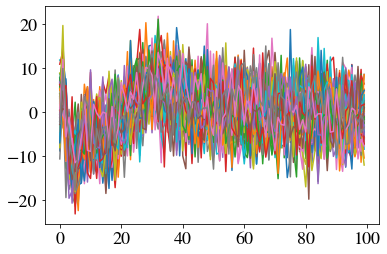

In [62]:
for roi_ix in range(68):
    plt.plot(data.X[10][roi_ix])

# Simu

In [12]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
def SIS_GLIM(data, basis_mat, keep_ratio=0.3, model_type="logi", input_paras={}, SIS_pen=1):
    """The function is to do the sure ind screening when d (num of ROIs) is large under GLIM
       Ref to FanAoS2010
    """
    _paras = edict(input_paras.copy())
    num_kp = int(np.round(len(_paras.sel_idx)*keep_ratio, 0))
    N = basis_mat.shape[1]
    if model_type.lower().startswith("lin"):
        if SIS_pen == 0:
            clf = LinearRegression(fit_intercept=False)
        else:
            clf = Ridge(fit_intercept=False, alpha=SIS_pen)
    elif model_type.lower().startswith("log"):
        clf = LogisticRegression(fit_intercept=False, random_state=0, C=1/SIS_pen)
        
        
    tbets = []
    for roi_ix in _paras.sel_idx:
        Xl = data.X[:, roi_ix];
        Sl = (Xl.unsqueeze(-1) * basis_mat.unsqueeze(0)).mean(axis=1); # num of sbj x N
        cur_X = torch.cat([data.Z.clone(), Sl], axis=1);
        clf = clf.fit(cur_X.numpy(), data.Y.numpy())
        if model_type.lower().startswith("lin"):
            tgam = clf.coef_[data.Z.shape[1]:]
        elif model_type.lower().startswith("log"):
            tgam = clf.coef_[0][data.Z.shape[1]:]
        tbet = basis_mat.numpy() @ tgam;
        tbets.append(tbet)
    tbets = np.array(tbets);
    norm_vs = np.sqrt(np.mean(tbets**2, axis=1));
    keep_idxs = np.sort(np.argsort(-norm_vs)[:num_kp])
    return _paras.sel_idx[keep_idxs], norm_vs

## One time

In [10]:
data_lin = _gen_simu_data_all_linear(1, paras);
data_logi = _gen_simu_data_all(1, paras);
basis_mat = paras.basis_mats[1];
keep_ratio = 0.3
input_paras = paras
ridge_pen = 1
model_type = "Logi" # or "Linear"

'Logi'

In [11]:
SIS_GLIM(data_logi, basis_mat, input_paras=paras, model_type="logi")

(array([ 5,  6, 12, 20, 21, 23, 24, 25, 31, 35, 40, 41, 45, 48, 49]),
 array([0.09572371, 0.12421089, 0.10190923, 0.12105885, 0.2736974 ,
        0.18978499, 0.10267235, 0.16260608, 0.14737045, 0.12136038,
        0.10881577, 0.21469687, 0.12146507, 0.04463251, 0.17127476,
        0.15129547, 0.12798112, 0.05728026, 0.09415319, 0.24530704,
        0.19216601, 0.06047954, 0.28737487, 0.25399517, 0.31249887,
        0.08910311, 0.17288966, 0.06203061, 0.0797308 , 0.05229787,
        0.20470089, 0.06169277, 0.15047209, 0.14130178, 0.39275409,
        0.09668569, 0.14441577, 0.04982321, 0.15232474, 0.26803061,
        0.19290051, 0.13519248, 0.07429146, 0.09722368, 0.24936655,
        0.12544275, 0.11564954, 0.18667697, 0.56327092]))

In [13]:
SIS_GLIM(data_lin, basis_mat, input_paras=paras, model_type="lin", SIS_pen=1)

(array([ 1,  8, 11, 16, 18, 19, 20, 30, 35, 36, 39, 40, 45, 48, 49]),
 array([0.32842954, 0.20649929, 0.14711255, 0.06695871, 0.23318261,
        0.18948799, 0.21367264, 0.34507739, 0.15641553, 0.06287044,
        0.33078152, 0.27631219, 0.19440094, 0.2287634 , 0.18101487,
        0.36646681, 0.26498701, 0.4225144 , 0.39748636, 0.38185695,
        0.06791201, 0.12284213, 0.12306106, 0.18509838, 0.19411622,
        0.14583482, 0.14670107, 0.20414093, 0.18851737, 0.36319749,
        0.2686109 , 0.12205839, 0.29206194, 0.28209529, 0.30560107,
        0.32401494, 0.21624683, 0.26229621, 0.32323048, 0.30389642,
        0.20474416, 0.18227863, 0.09979183, 0.17412261, 0.40964484,
        0.20513882, 0.18858406, 0.47663627, 1.27850897]))

## Multipe

### Sinica + linear

In [12]:
basis_mat = paras.basis_mats[2];
keep_ratio = 0.1
input_paras = paras
SIS_pen = 1

keep_idxss = []
for seed in trange(100):
    data_lin = _gen_simu_data_all_linear(seed, paras);
    keep_idxs, _ = SIS_GLIM(data_lin, basis_mat, input_paras=paras, model_type="lin", SIS_pen=SIS_pen)
    keep_idxss.append(keep_idxs)
keep_idxss = np.array(keep_idxss);    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.10it/s]


In [13]:
np.mean(keep_idxss[:, -1] == paras.d-1)

1.0

### Sinica + logi

In [14]:
paras.alp_GT = np.array([-1, -1, 2])
data = _gen_simu_data_all(0, paras)
data.Y.mean()

tensor(0.5100)

In [15]:
basis_mat = paras.basis_mats[2];
keep_ratio = 0.2
input_paras = paras
SIS_pen = 1

keep_idxss = []
for seed in trange(100):
    data = _gen_simu_data_all(seed, paras);
    keep_idxs, _ = SIS_GLIM(data, basis_mat, input_paras=paras, model_type="logi", SIS_pen=SIS_pen)
    keep_idxss.append(keep_idxs)
keep_idxss = np.array(keep_idxss);    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.72it/s]


In [16]:
np.mean(keep_idxss[:, -1] == paras.d-1)

1.0

### PSD + linear

In [18]:
basis_mat = paras.basis_mats[2];
keep_ratio = 0.2
input_paras = paras
SIS_pen = 1

keep_idxss = []
for seed in trange(100):
    data = _gen_simu_data_all_linear_PSD(seed, paras);
    keep_idxs, _ = SIS_GLIM(data, basis_mat, input_paras=paras, model_type="linear", SIS_pen=SIS_pen)
    keep_idxss.append(keep_idxs)
keep_idxss = np.array(keep_idxss);    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.42it/s]


In [19]:
np.mean(keep_idxss[:, -1] == paras.d-1)

1.0

### PSD + logi

In [26]:
paras.alp_GT = np.array([-4, -1, 2])
data = _gen_simu_data_all_PSD(1, paras)
data.Y.mean()

tensor(0.4250)

In [37]:
basis_mat = paras.basis_mats[2];
keep_ratio = 0.2
input_paras = paras
SIS_pen = 0.1 

keep_idxss = []
for seed in trange(100):
    data = _gen_simu_data_all_PSD(seed, paras);
    keep_idxs, _ = SIS_GLIM(data.Y, data.X, data.Z, basis_mat, keep_ratio=keep_ratio, input_paras=paras, model_type="logi", SIS_pen=SIS_pen)
    keep_idxss.append(keep_idxs)
keep_idxss = np.array(keep_idxss);    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


In [38]:
np.mean(keep_idxss[:, -1] == paras.d-1)

0.95

In [39]:
seed = 0
data = _gen_simu_data_all_PSD(seed, paras);
keep_idxs, _ = SIS_GLIM(data.Y, data.X, data.Z, basis_mat, keep_ratio=keep_ratio, input_paras=paras, model_type="logi", SIS_pen=SIS_pen)

In [40]:
keep_idxs

array([ 7, 10, 26, 27, 28, 32, 42, 50, 56, 62, 64, 65, 67])

In [33]:
data.Z.sum()

tensor(305.)